# E-Commerce Data Analysis Project
## Portfolio Showcase

**Author:** Nisarg Patel
**Date:** 2026

### Executive Summary
This project analyzes a Brazilian Ecommerce dataset to uncover customer segmentation insights and logistics performance bottlenecks. Key findings include:
- **Customer Segmentation:** Identified distinct groups using RFM analysis, revealing a significant "Hibernating" segment.
- **Logistics:** Discovered a "Disappointment Cliff" where delivery delays beyond 3 days correlate with a sharp drop in customer satisfaction (review scores < 3.0).

### Project Structure
- `Phase 1`: Data Loading, Cleaning, and Master Table Creation
- `Phase 2`: RFM Analysis and Customer Segmentation
- `Phase 3`: Logistics Performance and "Disappointment Cliff" Analysis


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
BASE_PATH = '../data/'
VIS_PATH = '../visualizations/'

# Ensure visualization directory exists
os.makedirs(VIS_PATH, exist_ok=True)

print("Environment setup complete.")


Environment setup complete.


## Phase 1: Data Loading and Preprocessing


In [21]:
def load_data(base_path):
    """Loads all necessary datasets from the specified path."""
    files = {
        'customers': 'olist_customers_dataset.csv',
        'geolocation': 'olist_geolocation_dataset.csv',
        'order_items': 'olist_order_items_dataset.csv',
        'order_payments': 'olist_order_payments_dataset.csv',
        'order_reviews': 'olist_order_reviews_dataset.csv',
        'orders': 'olist_orders_dataset.csv',
        'products': 'olist_products_dataset.csv',
        'sellers': 'olist_sellers_dataset.csv',
        'category_translation': 'product_category_name_translation.csv'
    }
    
    data = {}
    for name, file_name in files.items():
        try:
            data[name] = pd.read_csv(os.path.join(base_path, file_name))
            print(f"Loaded {name}: {data[name].shape}")
        except FileNotFoundError as e:
            print(f"Error loading {name}: {e}")
            
    return data

data = load_data(BASE_PATH)


Loaded customers: (99441, 5)
Loaded geolocation: (1000163, 5)
Loaded order_items: (112650, 7)
Loaded order_payments: (103886, 5)
Loaded order_reviews: (99224, 7)
Loaded orders: (99441, 8)
Loaded products: (32951, 9)
Loaded sellers: (3095, 4)
Loaded category_translation: (71, 2)


In [22]:
def preprocess_timestamps(data):
    """Converts timestamp columns to datetime objects."""
    timestamp_cols = {
        'orders': ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                   'order_delivered_customer_date', 'order_estimated_delivery_date'],
        'order_items': ['shipping_limit_date'],
        'order_reviews': ['review_creation_date', 'review_answer_timestamp']
    }
    
    for df_name, cols in timestamp_cols.items():
        if df_name in data:
            for col in cols:
                if col in data[df_name].columns:
                    data[df_name][col] = pd.to_datetime(data[df_name][col])
    print("Timestamps converted.")
    return data

data = preprocess_timestamps(data)


Timestamps converted.


In [23]:
def create_master_orders(data):
    """Aggregates and merges data to create a master orders dataframe."""
    
    # 1. Aggregate Payments
    payments_agg = data['order_payments'].groupby('order_id')['payment_value'].sum().reset_index()
    
    # 2. Aggregate Reviews
    reviews_agg = data['order_reviews'].groupby('order_id')['review_score'].mean().reset_index()
    
    # 3. Merge
    orders_master = pd.merge(data['orders'], data['customers'], on='customer_id', how='left')
    orders_master = pd.merge(orders_master, payments_agg, on='order_id', how='left')
    orders_master = pd.merge(orders_master, reviews_agg, on='order_id', how='left')
    
    print(f"Orders Master created: {orders_master.shape}")
    return orders_master

orders_master = create_master_orders(data)


Orders Master created: (99441, 14)


In [24]:
def create_logistics_master(data, orders_master):
    """Creates a master dataframe for logistics analysis."""
    
    # Merge items with products and sellers
    logistics = pd.merge(data['order_items'], data['products'], on='product_id', how='left')
    logistics = pd.merge(logistics, data['sellers'], on='seller_id', how='left')
    logistics = pd.merge(logistics, data['category_translation'], on='product_category_name', how='left')
    
    # Handling missing categories
    logistics['product_category_name_english'] = logistics['product_category_name_english'].fillna('unknown')
    
    # Merge partial order info for timing
    cols_to_keep = ['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 
                    'order_estimated_delivery_date', 'order_delivered_carrier_date']
    logistics = pd.merge(logistics, data['orders'][cols_to_keep], on='order_id', how='left')
    
    print(f"Logistics Master created: {logistics.shape}")
    return logistics

logistics_master = create_logistics_master(data, orders_master)


Logistics Master created: (112650, 23)


## Phase 2: RFM Customer Segmentation


In [25]:
def calculate_rfm(orders_df):
    """Calculates Recency, Frequency, and Monetary value for customers."""
    
    # Filter for delivered orders
    delivered = orders_df[orders_df['order_status'] == 'delivered'].copy()
    
    # Reference date (max date in dataset + 1 day)
    max_date = delivered['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
    
    rfm = delivered.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'
    }).reset_index()
    
    rfm.rename(columns={
        'order_purchase_timestamp': 'Recency',
        'order_id': 'Frequency',
        'payment_value': 'Monetary'
    }, inplace=True)
    
    # Scoring (Quintiles)
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
    
    # Frequency (Custom binning due to low variance)
    def f_score(x):
        if x == 1: return 1
        if x == 2: return 4
        return 5
    rfm['F_Score'] = rfm['Frequency'].apply(f_score).astype(int)
    
    return rfm

rfm_idx = calculate_rfm(orders_master)
print(rfm_idx.head())


                 customer_unique_id  Recency  Frequency  Monetary  R_Score  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90        4   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19        4   
2  0000f46a3911fa3c0805444483337064      537          1     86.22        1   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62        2   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89        2   

   M_Score  F_Score  
0        4        1  
1        1        1  
2        2        1  
3        1        1  
4        4        1  


In [26]:
def segment_customer(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r >= 4 and f >= 4 and m >= 4: return 'Champions'
    if r >= 4 and f >= 1 and m >= 4: return 'Potential Loyalists'
    if r >= 4 and f == 1 and m < 4:  return 'Promising Newcomers'
    if r == 3 and f >= 1:            return 'About to Sleep'
    if r <= 2 and f >= 4:            return 'Loyalists' # Recoverable
    if r <= 2 and f >= 1 and m >= 4: return 'Lost High-Value'
    if r <= 2 and f == 1:            return 'Hibernating'
    return 'At Risk'

rfm_idx['Segment'] = rfm_idx.apply(segment_customer, axis=1)
print(rfm_idx['Segment'].value_counts())


Segment
Hibernating            22489
Promising Newcomers    21778
About to Sleep         18709
Potential Loyalists    14446
Lost High-Value        13739
Champions                990
Loyalists                988
At Risk                  219
Name: count, dtype: int64


In [ ]:
def plot_segments(rfm_df, save_path):
    plt.figure(figsize=(14, 6))
    
    # Count Plot
    plt.subplot(1, 2, 1)
    sns.countplot(y='Segment', data=rfm_df, order=rfm_df['Segment'].value_counts().index, palette='viridis')
    plt.title('Customer Distribution by Segment')
    
    # Monetary vs Recency Scatter (Sample)
    plt.subplot(1, 2, 2)
    sample = rfm_df.sample(min(5000, len(rfm_df)))
    sns.scatterplot(x='Recency', y='Monetary', hue='Segment', data=sample, palette='viridis', alpha=0.6)
    plt.title('Recency vs Monetary (Sample)')
    plt.ylim(0, 1000) # Cap for visibility
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'customer_segments.png'))
    plt.show()

plot_segments(rfm_idx, VIS_PATH)


## Phase 3: Logistics & The "Disappointment Cliff"


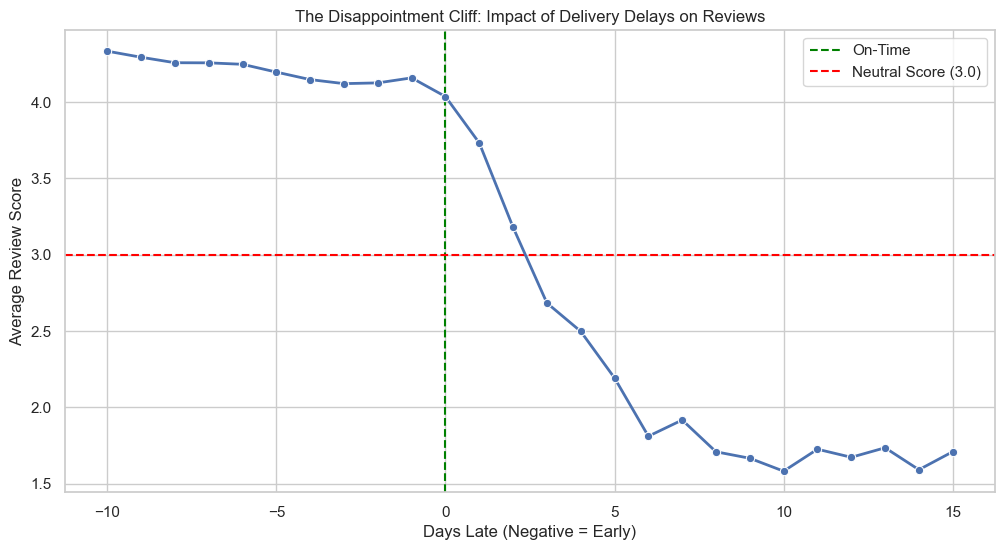

The review score drops below 3.0 (neutral) after 3.0 days of delay.


In [28]:
def analyze_delivery_impact(orders_df, save_path):
    """Analyzes the impact of delivery delays on review scores."""
    
    # Calculate Delay (Actual - Estimated)
    orders_df['delivery_delay_days'] = (orders_df['order_delivered_customer_date'] - orders_df['order_estimated_delivery_date']).dt.days
    
    # Filter valid range for visualization
    valid_delay = orders_df[(orders_df['delivery_delay_days'] >= -10) & (orders_df['delivery_delay_days'] <= 15)].copy()
    
    # Group by delay days
    cliff_data = valid_delay.groupby('delivery_delay_days')['review_score'].mean().reset_index()
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Visual cues for the cliff
    plt.axvline(x=0, color='green', linestyle='--', label='On-Time')
    plt.axhline(y=3.0, color='red', linestyle='--', label='Neutral Score (3.0)')
    
    sns.lineplot(x='delivery_delay_days', y='review_score', data=cliff_data, marker='o', linewidth=2)
    
    plt.title('The Disappointment Cliff: Impact of Delivery Delays on Reviews')
    plt.xlabel('Days Late (Negative = Early)')
    plt.ylabel('Average Review Score')
    plt.legend()
    
    plt.savefig(os.path.join(save_path, 'disappointment_cliff.png'))
    plt.show()
    
    # Identify the specific day it drops below 3.0
    cliff_day = cliff_data[cliff_data['review_score'] < 3.0]['delivery_delay_days'].min()
    print(f"The review score drops below 3.0 (neutral) after {cliff_day} days of delay.")

analyze_delivery_impact(orders_master, VIS_PATH)
